This aims to have the first view of data from RSNA Pneumonia Detection Challenge. It is to detect potential lung opacity region from medical images. The objective is drawing boxes containing these regions. 

Data includes images, cordinates determining boxes and labels if the person is sick or not. There are 2 files in \*.csv of about 30 000 records. We want to see what we have and potietial next steps we can do. 

In [40]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from glob import glob
import pydicom
import numpy as np
from scipy import stats

In [5]:
!ls ../Data/all

dog_cat				     stage_2_test_images.zip
GCP Credits Request Link - RSNA.txt  stage_2_train_images
stage_2_detailed_class_info.csv      stage_2_train_images.zip
stage_2_sample_submission.csv	     stage_2_train_labels.csv
stage_2_test_images


In [17]:
path_class='../Data/all/stage_2_detailed_class_info.csv'
path_image='../Data/all/stage_2_train_images'
path_target='../Data/all/stage_2_train_labels.csv'

We first check the two \*.csv data and see their strutures: features, number of records, unique values. 

In [14]:
data_class=pd.read_csv(path_class)
data_class.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [12]:
data_class.describe()

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     8dc8e54b-5b05-4dac-80b9-fa48878621e2  No Lung Opacity / Not Normal
freq                                       4                         11821

So there are only two columns: identity of patients and classes of their medical images.26 684 patients recorded but some are done several times (maximum is 4 times), only 3 classes that already appeared on the head of data: No Lung Opacity/Not Normal, Normal and Lung Opacity. Let's check the distribution of these 3 classes:

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

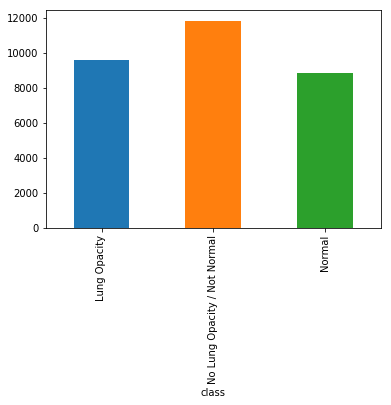

In [15]:
data_class.groupby('class').size().plot.bar()
data_class['class'].value_counts()

They are quite equivalent with a bit higher for No Lung Opacity/Nor Normal. We now can jump to the second data with imformation about boxes and labels.

In [18]:
data_target=pd.read_csv(path_target)
data_target.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [19]:
data_target['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

It seems that target 1 corresponds Lung Opacity. We will verify it latter. See if patientId is the same for the two data. 

In [20]:
data_target['patientId'].unique().shape

(26684,)

In [21]:
(data_target['patientId']==data_class['patientId']).sum()

30227

The answer is yes, the two data record the same observations: same patients, same repetition. So we can merge two data by concatenating them.

In [22]:
data=pd.concat([data_class, data_target.drop('patientId',1)],1)
data.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    NaN    NaN     NaN       0  
1    NaN    NaN     NaN       0  
2    NaN    NaN     NaN       0  
3    NaN    NaN     NaN       0  
4  152.0  213.0   379.0       1

In [23]:
data['x'].isnull().sum()

20672

I separate sick people and check the distribution of recorded patients because one record is equivalent to one box in one image. We have totally 25 684 patients, but some are recorded as many as 4 times, i.e. 4 boxes. Let's start.

In [24]:
sick_index=data['Target']==1
data_sick=data[sick_index]
data_sick.head()

patientId         class      x      y  width  \
4   00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  264.0  152.0  213.0   
5   00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  562.0  152.0  256.0   
8   00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  323.0  577.0  160.0   
9   00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  695.0  575.0  162.0   
14  00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity  288.0  322.0   94.0   

    height  Target  
4    379.0       1  
5    453.0       1  
8    104.0       1  
9    137.0       1  
14   135.0       1

In [25]:
data_sick['patientId'].describe()

count                                     9555
unique                                    6012
top       349f10b4-dc3e-4f3f-b2e4-a5b81448ce87
freq                                         4
Name: patientId, dtype: object

In [26]:
data_sick['class'].unique()

array(['Lung Opacity'], dtype=object)

This verifies that indeed target 1 is Lung Opacity. There are 8964 sick records but only 5659 patients. 

In [27]:
box_data = data_sick.groupby('patientId').size().reset_index(name='boxes')
box_dt = pd.merge(data_sick, box_data, on='patientId')
box_dt.groupby('boxes').size().reset_index(name='patients')

boxes  patients
0      1      2614
1      2      6532
2      3       357
3      4        52

# Incoporate images

It is time to incoporated the images. We will visualize some images with boxes on it.

In [30]:
image_data = pd.DataFrame({'path': glob(os.path.join(path_image, '*.dcm'))})
image_data.shape

(26684, 1)

DICOM data is used to store medical image. It contains not only image but also attached information in mega data part. Let's see what information is combined with image.

In [31]:
img0=pydicom.read_file(image_data['path'][0],stop_before_pixels=True)
img0

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.15812.1517874393.200568
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '5cf7f474-7d2f-4e7e-acb4-c4d152fdb478'
(0010, 0020) Patient ID                          LO: '5cf7f474-7d2f-4e7e-acb4-c4d152fdb478'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

So now we know that there are some features perhaps usefull to prediction. We will extract them out.

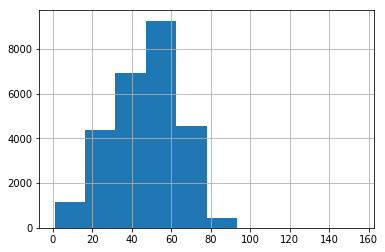

In [32]:
add_features=['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in add_features}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_features = image_data.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_features['PatientAge'] = image_features['PatientAge'].map(int)
image_features['PatientAge'].hist()

In [33]:

image_features.drop('path',1).describe(exclude=np.number)


BodyPartExamined ViewPosition PatientSex
count             26684        26684      26684
unique                1            2          2
top               CHEST           PA          M
freq              26684        14511      15166

We would like to combine image data to information data, so we will verify if the two are compatible.

In [34]:
image_data['patientId'] = image_data['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
img_ids = set(image_data['patientId'].values.tolist())
data_ids = set(data_target['patientId'].values.tolist())
assert img_ids.union(data_ids)==data_ids, "Patient IDs should be the same"

In [35]:
image_full_data=pd.merge(image_data, image_features.drop('BodyPartExamined',1), on='path')
data_full=pd.merge(data, image_full_data, on='patientId', how='left')
data_full.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  \
0    NaN    NaN     NaN       0   
1    NaN    NaN     NaN       0   
2    NaN    NaN     NaN       0   
3    NaN    NaN     NaN       0   
4  152.0  213.0   379.0       1   

                                                path  PatientAge ViewPosition  \
0  ../Data/all/stage_2_train_images/0004cfab-14fd...          51           PA   
1  ../Data/all/stage_2_train_images/00313ee0-9eaa...          48           PA   
2  ../Data/all/stage_2_train_images/00322d4d-1c29...          19           AP   
3  ../Data/all/stage_2_train_images/003d8fa0-6bf1...          28           PA   
4  ../Data/all/stage_2_train_images/00436515-870c...          32           AP   

  PatientSex  
0          F  
1          F  
2          M  
3          M  
4          F

# Some statistical views on mega data

Since we have some features of patients, I am curious about them. How gender and age affect the disease and if ViewPosition has any correlation with it. 

In [36]:
gender_table=pd.crosstab(data_full.Target, data_full.PatientSex, margins=True)
gender_table.columns=['F','M','col']
gender_table.index=['0','1','row']
gender_table/gender_table.loc['row']
# gender_table

F         M       col
0    0.692952  0.677045  0.683892
1    0.307048  0.322955  0.316108
row  1.000000  1.000000  1.000000

It seems gender has little impact to disease, but no harm to check. We use z-test for odds ratio.

In [41]:
gender_table=pd.crosstab(data_full.Target, data_full.PatientSex)
#gender_table
stats.fisher_exact(gender_table)

(1.0765206679935369, 0.0033275433900041684)

So even the number dipicted not much difference, we actually cannot reject the null hypothesis, i.e we cannot reject the hypothesis that gender doesn't affect the disease. We better include gender to our model.

In [42]:
view_table=pd.crosstab(data_full.Target, data_full.ViewPosition, margins=True)
view_table.index=['0','1','row']
view_table/view_table.loc['row']

ViewPosition        AP        PA       All
0             0.490881  0.881648  0.683892
1             0.509119  0.118352  0.316108
row           1.000000  1.000000  1.000000

VierPosition apparently has strong relationship to the value of target. PA leads to much more healthy patient than AP. A statistical test confirms it.

In [43]:
view_table=pd.crosstab(data_full.Target, data_full.ViewPosition)
stats.fisher_exact(view_table)

(0.1294308578687494, 0.0)

The main objective of the challenge is drawing boxes. I am however curious about target, what if we are really interested in 3 level target not 2 level? Let's check again the association of gender and age on the target with 3 levels.

In [53]:
gender_class_table=pd.crosstab(data_full['class'], data_full.PatientSex, margins=True)
gender_class_table
gender_class_table.columns=['F','M','col']
gender_class_table.index=['Lung','Not Normal','Normal','row']
gender_class_table/gender_class_table.loc['row']

F         M       col
Lung        0.307048  0.322955  0.316108
Not Normal  0.392821  0.389754  0.391074
Normal      0.300131  0.287291  0.292818
row         1.000000  1.000000  1.000000

We use Chi-Square Test of Independence to conduct the test for association between gender and target.

In [54]:
gender_class_table=pd.crosstab(data_full['class'], data_full.PatientSex)
stats.chi2_contingency(gender_class_table)

(10.282738204639061,
 0.005849675424204782,
 2,
 array([[4112.88268766, 5442.11731234],
        [5088.26648361, 6732.73351639],
        [3809.85082873, 5041.14917127]]))

The p-value is smaller than 0.05 (even though quite close) which indicates that there might be an association between the two variables. However we suspect that the target is ordinal (order), so we might better use Cochran–Armitage test for trend. For this test, we need to conduct it from scratch.

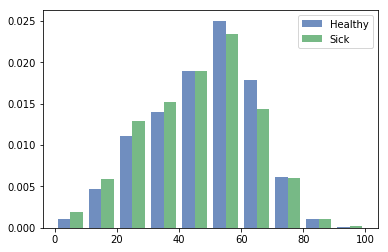

In [55]:
from matplotlib import pyplot
healthy_age=data_full.PatientAge[data_full.Target==0]
sick_age=data_full.PatientAge[data_full.Target==1]
bins=[0,10,20,30,40,50,60,70,80,90,100]
plt.style.use('seaborn-deep')
pyplot.hist([healthy_age,sick_age],\
            bins, alpha=0.8, label=['Healthy','Sick'], density=True)
# pyplot.hist(data_full.PatientAge[data_full.Target==1], bins, alpha=0.5, label='Sick', density=True)
pyplot.legend(loc='upper right')
pyplot.show()

In [56]:
print(healthy_age.mean(), healthy_age.var())
print(sick_age.mean(),sick_age.var())

47.45099651702786 275.2609142988607
45.38451072736787 304.3555900761619


In [57]:
stats.ttest_ind(sick_age, healthy_age, equal_var = True)

Ttest_indResult(statistic=-9.904503399562147, pvalue=4.315337056500132e-23)

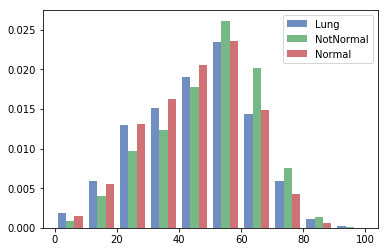

In [58]:
lung_age=data_full.PatientAge[data_full['class']=='Lung Opacity']
notNormal_age=data_full.PatientAge[data_full['class']=='No Lung Opacity / Not Normal']
normal_age=data_full.PatientAge[data_full['class']=='Normal']
bins=[0,10,20,30,40,50,60,70,80,90,100]
plt.style.use('seaborn-deep')
pyplot.hist([lung_age,notNormal_age, normal_age],\
            bins, alpha=0.8, label=['Lung','NotNormal','Normal'], density=True)
# pyplot.hist(data_full.PatientAge[data_full.Target==1], bins, alpha=0.5, label='Sick', density=True)
pyplot.legend(loc='upper right')
pyplot.show()

In [59]:
stats.f_oneway(lung_age, notNormal_age,normal_age)

F_onewayResult(statistic=223.52603143049365, pvalue=4.3133709684483133e-97)

The two above tests (t-test for two-level outcome and one-way ANOVA for three-level outcome) show that age has a strong relationship with our target whatever we consider it as two or three level. We should definitely include age to our model.

# Visualize images

In [60]:
data_full0=pd.merge(data_full, box_data, on='patientId', how='left')
data_full0.boxes.fillna(0, inplace=True)
data_full0.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  \
0    NaN    NaN     NaN       0   
1    NaN    NaN     NaN       0   
2    NaN    NaN     NaN       0   
3    NaN    NaN     NaN       0   
4  152.0  213.0   379.0       1   

                                                path  PatientAge ViewPosition  \
0  ../Data/all/stage_2_train_images/0004cfab-14fd...          51           PA   
1  ../Data/all/stage_2_train_images/00313ee0-9eaa...          48           PA   
2  ../Data/all/stage_2_train_images/00322d4d-1c29...          19           AP   
3  ../Data/all/stage_2_train_images/003d8fa0-6bf1...          28           PA   
4  ../Data/all/stage_2_train_images/00436515-870c...          32           AP   

  PatientSex  boxes  
0          F    0.0  
1          F    0.0  
2          M    0.0  
3          M    0.0  
4          F    2.0

In [61]:
sample = data_full0.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample.shape

(12, 12)

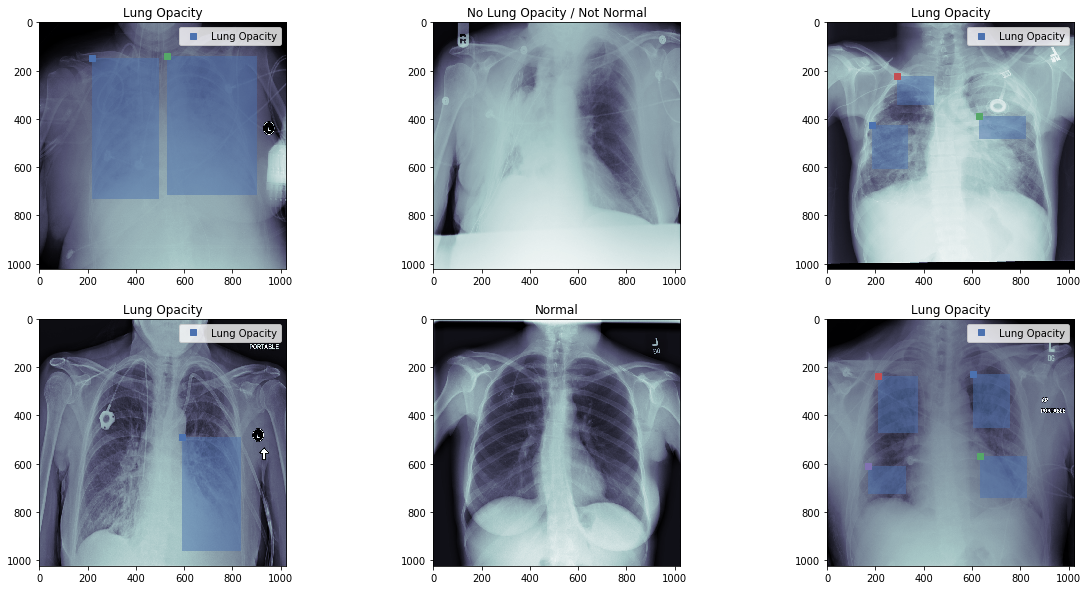

In [62]:
from matplotlib.patches import Rectangle
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

../Data/all/stage_2_train_images/05eebe4c-bca2-40d4-bb20-54fc60e2bcea.dcm
../Data/all/stage_2_train_images/0c7c5bbd-b443-422c-b772-a8bd90900647.dcm
../Data/all/stage_2_train_images/2cd0cbc4-bf35-49de-963e-8ee3fd08ca75.dcm
../Data/all/stage_2_train_images/a3476eba-8536-4271-a7a9-b13dc3cc8a4d.dcm
../Data/all/stage_2_train_images/ecbe84f7-1283-4131-bea3-d8b380179c47.dcm
../Data/all/stage_2_train_images/ee820aa5-4804-4984-97b3-f0a71d69702f.dcm


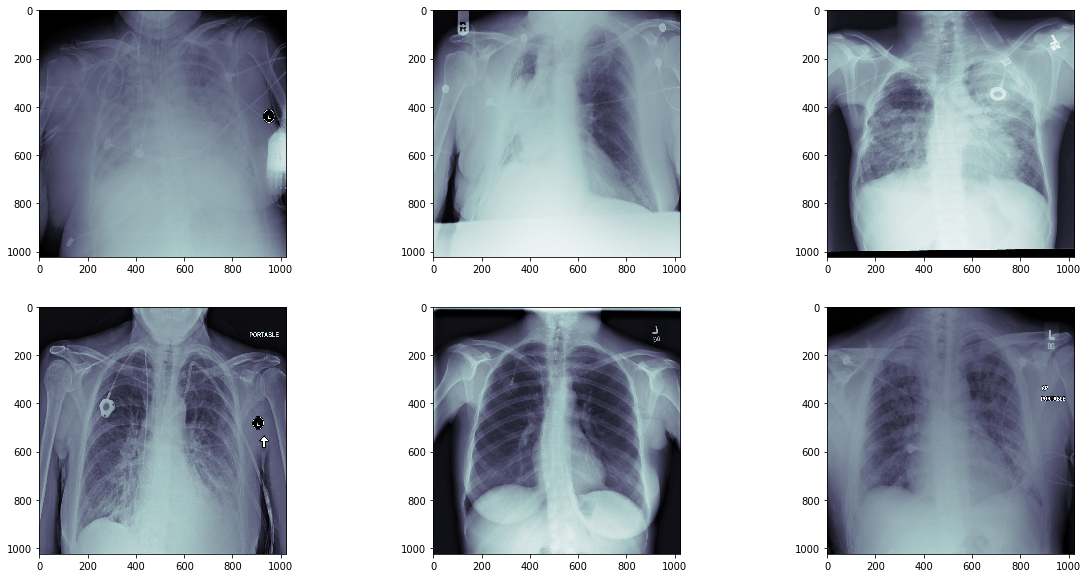

In [63]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, _) in zip(m_axs.flatten(),
                    sample.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    print(c_path)

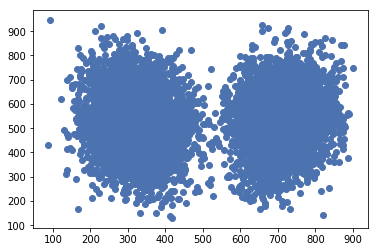

In [64]:
x_center=box_dt.x+box_dt.width*0.5
y_center=box_dt.y+box_dt.height*0.5
pyplot.scatter(x=x_center, y=y_center)

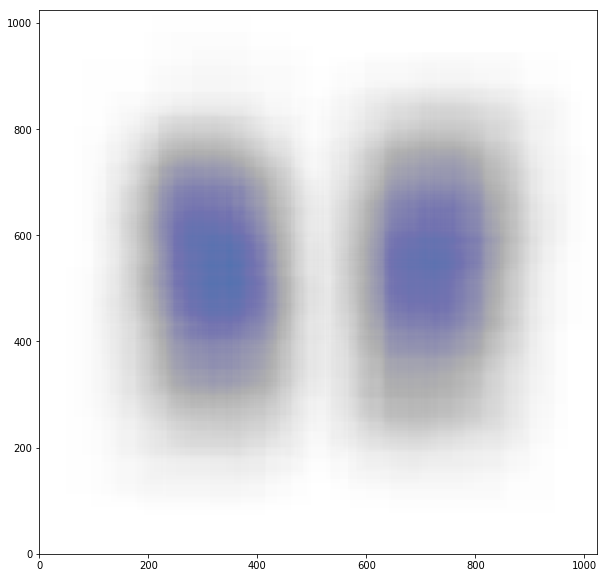

In [65]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in box_dt.sample(500).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

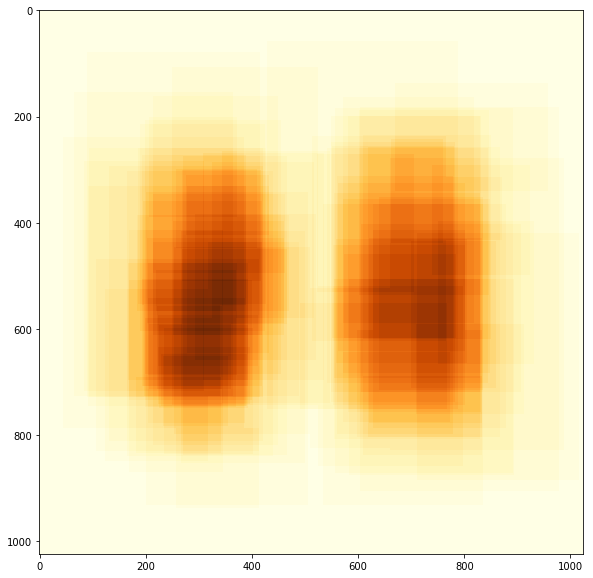

In [66]:
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in box_dt.sample(100).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='YlOrBr')

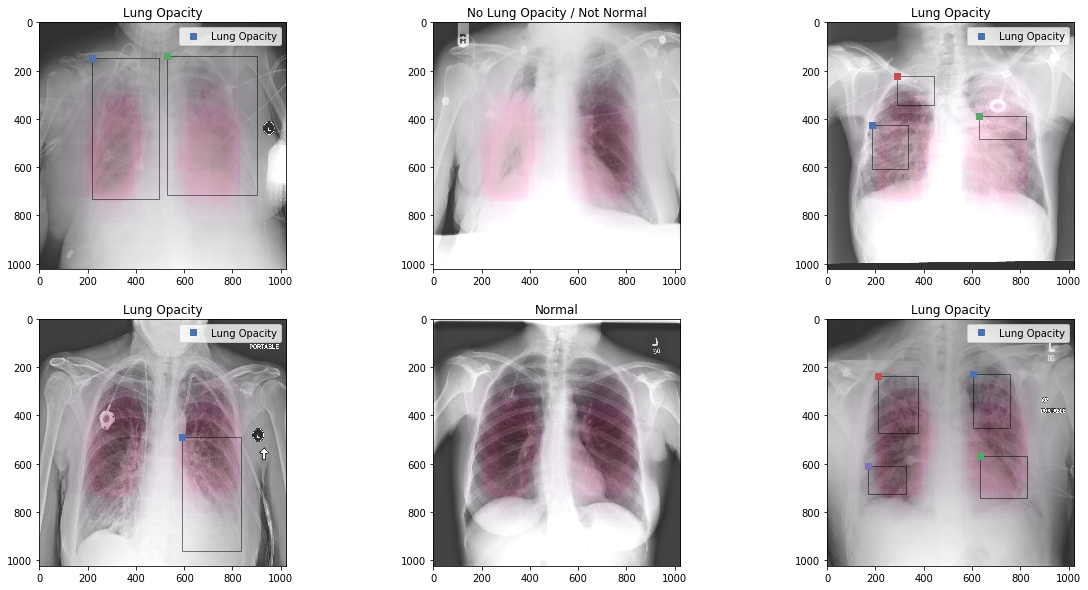

In [67]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.2*plt.cm.PuRd(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

In [70]:
data_full0.x[data_full0.Target==1].hist(bins=20)

We have bimodal x for left and right lung.

In [71]:
data_full0.y[data_full0.Target==1].hist(bins=40)

In [74]:
sick_data=data_full[data_full.Target==1]
stats.ttest_ind(sick_data.height[data_full.ViewPosition=='PA'], sick_data.height[data_full.ViewPosition=='AP'], equal_var = True)

Ttest_indResult(statistic=-28.01009512233515, pvalue=5.495119483047264e-166)

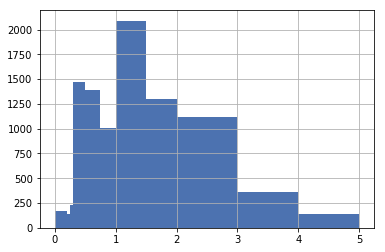

In [73]:
(sick_data.x/sick_data.y).hist(bins=[0,0.2,0.25,0.3,0.5, 0.75, 1,1.5,2,3,4,5])

t-test suggests that we should include gender and view position into prediction model for coordinates x, y, width and height.